# Training Module for Neural Network Model

# Import Libraries

In [1]:
# Import essential libraries
import os
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from plib.data import get_data,minmax_norm,data_split
from plib.feature_selection import out_features
from plib.p_metric import main_perf_metrics_calc


#NN
from numpy import random, dot, tanh
from ACSO_Ensemble import rider

#DNFN & Keras modules and its important APIs
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam as opti

#from ACSO_Ensemble.FuzzyLayer import FuzzyLayer
from ACSO_Ensemble.DefuzzyLayer import DefuzzyLayer



# Read and Process Dataset

In [2]:
X_train ,Y_train,train_df =get_data('./plib/dataset/Cleveland.csv')
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
train_df.describe()

Number of rows: 302;  Number of columns: 14; No of missing values 6
Shape of X_train: (302, 13)
Shape of y_train: (302,)


,63,1,1.1,145,233,1.2,2,150,0,2.3,3,0.2
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


# Data Normalization

In [3]:
X_train=minmax_norm(X_train)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
classes=len(np.unique(Y_train))
print("Classes: ",classes)

Shape of X_train: (302, 13)
Shape of y_train: (302,)
Classes:  5


# Split Data for Train and Test

In [4]:
xtrain, xvalid, ytrain, yvalid,fold=data_split(X_train,Y_train,test_size=0.2)
print("Shape of X_train:", xtrain.shape)
print("Shape of y_train:", ytrain.shape)
print("Shape of X_test:", xvalid.shape)
print("Shape of y_test:", yvalid.shape)


Shape of X_train: (241, 13)
Shape of y_train: (241,)
Shape of X_test: (61, 13)
Shape of y_test: (61,)


# Feature Selection

In [5]:
opts = {'k':5, 'fold':fold, 'N':X_train.shape[0], 'T':7, 'w':0.7, 'c1':2, 'c2':2}
x_train, x_test, y_train, y_test,b_feat= out_features(X_train,Y_train,opts,xtrain, xvalid, ytrain, yvalid)
print ("Number of Best Features: ",b_feat)

sel_feat_ratio=60
w=round(x_train.shape[1]*sel_feat_ratio/100)
print(b_feat,w)
if w > b_feat:
    x_train=x_train[:,0:  w]
    x_test=x_test[:,0:w]
    print("Seleted Feature Composition: ",x_train.shape,x_test.shape)
    print('You choosed worse features too.')
else:
    x_train=x_train[:,0:  w]
    x_test=x_test[:,0:w]
    print("Seleted Feature Composition: ",x_train.shape,x_test.shape)
encoder = LabelEncoder()
y_train=encoder.fit_transform(y_train.reshape(-1, 1))
y_test=encoder.fit_transform(y_test.reshape(-1, 1))
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
  
print("Shape of X_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Iteration: 1
Best (PSO): 0.7575091046729733
Iteration: 2
Best (PSO): 0.7484338457520073
Iteration: 3
Best (PSO): 0.746342028347726
Iteration: 4
Best (PSO): 0.7456133072314338
Iteration: 5
Best (PSO): 0.7456133072314338
Run Time --- 0.8224070072174072 seconds ---
Number of Best Features:  5
5 8
Seleted Feature Composition:  (241, 8) (61, 8)
You choosed worse features too.
Shape of X_train: (241, 8)
Shape of y_train: (241, 5)
Shape of X_test: (61, 8)
Shape of y_test: (61, 5)


# Defining Performance Evaluation Functions

In [6]:
measures_table=dict()

In [7]:
len(x_train[0])
print(x_train.shape,y_train.shape)
print(x_train)

(241, 8) (241, 5)
[[0.19057715 0.00568887 0.00568887 ... 0.00284444 0.01137774 0.45510962]
 [0.22578128 0.01010961 0.00673974 ... 0.00336987 0.01347948 0.40438438]
 [0.10873796 0.01175546 0.00881659 ... 0.00293886 0.00881659 0.38205231]
 ...
 [0.11673514 0.         0.00277941 ... 0.00277941 0.00555882 0.33352898]
 [0.13485821 0.         0.00328922 ... 0.00328922 0.00657845 0.3618147 ]
 [0.11045797 0.         0.0026941  ... 0.         0.00538819 0.33945621]]


# DNFN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 16)                5

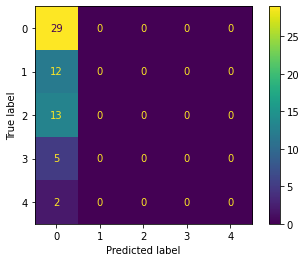

Accuracy, sensitivity, specificity, Precision, F1-score
(0.5273264401772526, 0.47540983606557374, 0.5698924731182795, 0.47540983606557374, 0.47540983606557374)


In [8]:
#DNFN
os.environ['TF_GPU_THREAD_MODE']='gpu_private'
os.environ['TF_GPU_THREAD_COUNT']='1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model = tf.keras.models.Sequential()
def classify(x_train, x_test, y_train):

    model.add(Dense(64, input_dim=x_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(classes,activation='softmax'))
    model.compile(metrics=['accuracy'], optimizer=opti(), loss=tf.keras.losses.categorical_crossentropy)
    model.summary()
    model.fit(x_train, y_train, batch_size=50, epochs=10, verbose=1)
    plot_model(model, to_file='model_DNFN1.jpg', show_shapes=True, dpi=400)
    
    return model

y_pred=classify(x_train, x_test, y_train).predict(x_test)
score=model.evaluate(x_test, y_test)
measures =main_perf_metrics_calc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),classes)
print(measures)
measures_table['DNFN'] = measures

In [9]:
 np.argmax(y_pred,axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [10]:
np.argmax(y_test,axis=1)

array([0, 2, 0, 2, 2, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0,
       4, 2, 2, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 3, 0, 2, 4,
       2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 3, 1, 1, 2, 3, 1, 0], dtype=int64)

# Neural Network

In [ ]:
'''os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
class NeuralNetwork():

    def __init__(self, dim):
        # Using seed to make sure it'll
        # generate same weights in every run
        random.seed(1)

        # 3x1 Weight matrix
        self.weight_matrix = 2 * random.random((dim, 1)) - 1

    # tanh as activation function
    def tanh(self, x):
        return tanh(x)

        # derivative of tanh function.

    # Needed to calculate the gradients.
    def tanh_derivative(self, x):
        return 1.0 - tanh(x) ** 2

    # forward propagation
    def forward_propagation(self, inputs):
        return self.tanh(dot(inputs, self.weight_matrix)), random.uniform(0, 1, size=len(inputs))

    # training the neural network.
    def train(self, train_inputs, train_outputs,
              num_train_iterations):
        # Number of iterations we want to
        # perform for this set of input.
        for iteration in range(num_train_iterations):
            output, x = self.forward_propagation(train_inputs)

            # Calculate the error in the output.
            error = train_outputs - output

            # multiply the error by input and then
            # by gradient of tanh funtion to calculate
            # the adjustment needs to be made in weights
            adjustment = dot(train_inputs.T, error *
                             self.tanh_derivative(output))

            # Adjust the weight matrix
            self.weight_matrisx += adjustment * rider.Alg()


def classify(x_train, x_test, y_train):
    nc = 2
    train_outputs = np.array([y_train]).T
    neural_network = NeuralNetwork(len(x_train[0]))
    neural_network.train(np.array(x_train), train_outputs, 10)

    # Test the neural network with a new situation.
    x, pred = neural_network.forward_propagation(x_test)

    predict = []
    for i in range(len(pred)):
        predict.append(np.abs(np.round(pred[i])))
    if len(np.unique(predict)) != nc:
        for i in range(nc): predict[i]=i
    return predict

y_pred=classify(x_train, x_test, y_train)


measures =main_perf_metrics_calc(y_test, y_pred)
print(measures)
measures_table['NN'] = measures'''


# Re-Write Neural Network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 241)               2169      
                                                                 
 dense_9 (Dense)             (None, 5)                 1210      
                                                                 
Total params: 3,379
Trainable params: 3,379
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 0s 4ms/step - loss: 1.5551 - accuracy: 0.4730
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 1.4828 - accuracy: 0.5560
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 1.4173 - accuracy: 0.5560
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 1.3640 - accuracy: 0.5560
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - 

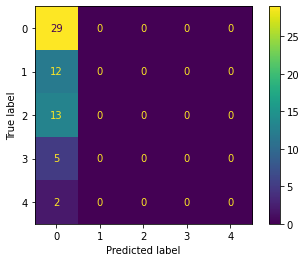

Accuracy, sensitivity, specificity, Precision, F1-score
(0.5273264401772526, 0.47540983606557374, 0.5698924731182795, 0.47540983606557374, 0.47540983606557374)


In [11]:
model = tf.keras.models.Sequential()
def Neural_Network(x_train, x_test, y_train):

    model.add(Dense(x_train.shape[0], input_dim=x_train.shape[1]))
    #model.add(Dense(classes, activation='tanh'))
    model.add(Dense(classes,activation='softmax'))
    model.compile(metrics=['accuracy'], optimizer=opti(), loss=tf.keras.losses.categorical_crossentropy)
    model.summary()
    model.fit(x_train, y_train, batch_size=50, epochs=10, verbose=1)
    plot_model(model, to_file='model_DNFN1.jpg', show_shapes=True, dpi=400)
    
    return model

y_pred=Neural_Network(x_train, x_test, y_train).predict(x_test)
score=model.evaluate(x_test, y_test)
measures =main_perf_metrics_calc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),classes)
print(measures)
measures_table['NN'] = measures

# Ride NN

Epoch 1/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.8000
Epoch 10/10
2/2 [==============================] - 0s 0s/step


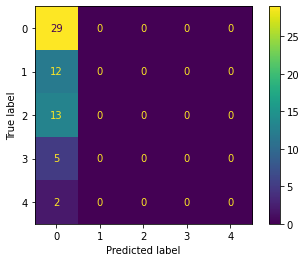

Accuracy, sensitivity, specificity, Precision, F1-score
(0.5273264401772526, 0.47540983606557374, 0.5698924731182795, 0.47540983606557374, 0.47540983606557374)


In [12]:
def classify(x_train, y_train, x_test, y_test):

    # Setting Training Hyperparameters
    batch_size = 128  # original ResNet paper uses batch_size = 128 for training
    epochs = 10
    data_augmentation = False
    num_classes = 1#len(np.unique(y_train))

    # Data Preprocessing
    subtract_pixel_mean = True
    n = 3

    # Select ResNet Version
    version = 1

    # Computed depth of
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet % dv % d' % (depth, version)

    xt = len(x_train)
    yt = len(x_test)

    #x_train = np.resize(x_train, (xt, 32, 32, 3))
    #x_test = np.resize(x_test, (yt, 32, 32, 3))
    # Input image dimensions.
    input_shape = x_train.shape[1]

    #y_train = np.array(y_train)
    #y_test = np.array(y_test)
    #y_train = y_train.astype('int')
    # Normalize data.
    #x_train = x_train.astype('float32') / 255
    #x_test = x_test.astype('float32') / 255
    #y_test = y_test.astype('int')

    # Convert class vectors to binary class matrices.
    #y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    #y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # Setting LR for different number of Epochs
    def lr_schedule(epoch):
        lr = 0.1
        if epoch > 180:
            lr *= 0.5e-3
        elif epoch > 160:
            lr *= 1e-3
        elif epoch > 120:
            lr *= 1e-2
        elif epoch > 80:
            lr *= 1e-1
        return lr

        

    #
    def resnet_v1(input_shape, depth, num_classes=num_classes):
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
        # Start model definition.
        num_filters = 16
        num_res_blocks = int((depth - 2) / 6)

        inputs = Input(shape=input_shape)
        x = inputs

        # Instantiate the stack of residual units
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides = 2  # downsample
                y = x
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x = y
                x = keras.layers.add([x, y])
                x = Activation('relu')(x)
            num_filters *= 2

        # Add classifier on top.
        # v1 does not use BN after last shortcut connection-ReLU
        #x = AveragePooling2D(pool_size=8)(x)
        y = Flatten( )(x)
        outputs = Dense(num_classes,
                        activation='sigmoid',
                        kernel_initializer='he_normal')(y)

        # Instantiate model.
        model = Model(inputs=inputs, outputs=outputs)
        return model

    # ResNet V2 architecture
    def resnet_v2(input_shape, depth, num_classes=num_classes):
        if (depth - 2) % 9 != 0:
            raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
        # Start model definition.
        num_filters_in = 16
        num_res_blocks = int((depth - 2) / 9)

        inputs = Input(shape=input_shape)
        # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
        x = inputs
        # Instantiate the stack of residual units
        for stage in range(3):
            for res_block in range(num_res_blocks):
                activation = 'relu'
                batch_normalization = True
                strides = 1
                if stage == 0:
                    num_filters_out = num_filters_in * 4
                    if res_block == 0:  # first layer and first stage
                        activation = None
                        batch_normalization = False
                else:
                    num_filters_out = num_filters_in * 2
                    if res_block == 0:  # first layer but not first stage
                        strides = 2  # downsample

                # bottleneck residual unit
                y = x
                if res_block == 0:
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x =y
                x = keras.layers.add([x, y])

            num_filters_in = num_filters_out

        # Add classifier on top.
        # v2 has BN-ReLU before Pooling
        x = BatchNormalization( )(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=8)(x)
        y = Flatten( )(x)
        outputs = Dense(classes,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # Instantiate model.
        model = Model(inputs=inputs, outputs=outputs)
        return model

    # Main function
    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss=tf.keras.losses.MSE,
                  optimizer=opti(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=50, epochs=10, verbose=1)
    # Prediction.
    pred = model.predict(x_test)
    return pred
y_pred=classify(x_train, y_train, x_test, y_test)

measures =main_perf_metrics_calc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),classes)
print(measures)
measures_table['Ride NN'] = measures


# Showing All performance Measures for All Classifier in Table

In [13]:
def header():
    for x in range(90):
        print ('-',end = '')
    print('')
    
header()
print ("{:<10} | {:<11} | {:<11} | {:<11} | {:<10} | {:<10}".format('Classifier','Accuracy %', 'Sensitivity', 'Specificity','Precision','F1-Score'))
 
# print each data item.
for key, value in measures_table.items():
    Acc,Sen,Spec,Prec,F1 = value
#    header()
    if key == 'GradientBoosting':
        key ='Gradient'
    print ("{:<10} | {:<11} | {:<11} | {:<11} | {:<10} | {:<10} ".format(key,round(Acc*100,3),round(Sen,3),round(Spec,3),round(Prec,3),round(F1,3)))
header()

------------------------------------------------------------------------------------------
Classifier | Accuracy %  | Sensitivity | Specificity | Precision  | F1-Score  
DNFN       | 52.733      | 0.475       | 0.57        | 0.475      | 0.475      
NN         | 52.733      | 0.475       | 0.57        | 0.475      | 0.475      
Ride NN    | 52.733      | 0.475       | 0.57        | 0.475      | 0.475      
------------------------------------------------------------------------------------------


# Saving Results to File

In [14]:
# Create Folder for Results if not exist
if not os.path.exists('Results'):
    os.makedirs('Results')

In [15]:
#####################################################
                ## Using Pickle
################################################        
#import pickle
# Open a file and use dump()
#with open('results/NN.pkl', 'wb') as file:
    # A new file will be created
#    pickle.dump(measures_table, file)    

In [16]:
#####################################################
                ## Using CSV
################################################
# import csv
#w = csv.writer(open("Results/NN.csv", "wb"))

# loop over dictionary keys and values
#for key, val in measures_table.items():
#    print(key,val)
    # write every key and value to file
#    w.writerow([key, val])

In [17]:
#####################################################
                ## Using JSON
################################################
# load json module
# python dictionary with key value pairs

# create json object from dictionary
json = json.dumps(measures_table)

# open file for writing, "w" 
f = open("Results/NN.json","w")

# write json object to file
f.write(json)

# close file
f.close()